## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from datasets import load_from_disk

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.string_edit_metrics import get_string_edit_metrics, get_string_edit_metrics_ortho_and_norm
from normalization.whisper_normalization import get_whisper_normalizer
from utils.whisper_hallucinations.eval_filter_criterion import eval_filter_criterion
from utils.notebook_utils import listen_to_audio

whisper_norm = get_whisper_normalizer("english")
sns.set_theme(context="paper", style="ticks")

## Load cached dataset

In [4]:
dataset_name = "ami_validation"

savepath = f"notebooks/data/whisper_hallucinations_cached_ds/{dataset_name}"
ds = load_from_disk(savepath)

ds.features

{'text': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'teacher_text': Value(dtype='string', id=None),
 'teacher_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'audio_length': Value(dtype='float64', id=None),
 'n_tokens_labels': Value(dtype='int64', id=None),
 'n_tokens_teacher': Value(dtype='int64', id=None),
 'diff_n_tokens': Value(dtype='int64', id=None),
 'gzip_ratio': Value(dtype='float64', id=None),
 'teacher_gzip_ratio': Value(dtype='float64', id=None),
 'diff_gzip_ratio': Value(dtype='float64', id=None),
 'n_overlaps': Value(dtype='int64', id=None)}

## Convert to DataFrame

In [5]:
df = pd.DataFrame({col: ds[col] for col in ds.features.keys() if col != "audio"})

df.head()

,text,labels,teacher_text,teacher_labels,audio_length,n_tokens_labels,n_tokens_teacher,diff_n_tokens,gzip_ratio,teacher_gzip_ratio,diff_gzip_ratio,n_overlaps
0,but like mobile phones have screens and they'r...,"[50258, 50363, 5955, 411, 6013, 10216, 362, 11...",but like mobile phones have screens and they'...,"[50258, 50363, 457, 411, 6013, 10216, 362, 111...",2.68,14,15,1,0.757143,0.774648,0.017505,0
1,mm,"[50258, 50363, 2174, 50257]",you,"[50258, 50363, 291, 50257]",0.15,4,4,0,0.090909,0.166667,0.075758,0
2,furry,"[50258, 50363, 69, 30614, 50257]",furry.,"[50258, 50363, 47073, 13, 50257]",0.52,5,5,0,0.200000,0.259259,0.059259,0
3,yeah,"[50258, 50363, 19650, 50257]",yeah.,"[50258, 50363, 1338, 13, 50257]",1.86,4,5,1,0.166667,0.230769,0.064103,0
4,i mean it just seems like yeah,"[50258, 50363, 72, 914, 309, 445, 2544, 411, 1...",i mean it just seems like... yeah.,"[50258, 50363, 741, 914, 309, 445, 2544, 411, ...",2.27,10,12,2,0.600000,0.636364,0.036364,0


## First analysis

In [6]:
dict_string_edit_metrics = get_string_edit_metrics_ortho_and_norm(references=df["text"], predictions=df["teacher_text"], norm_fn=get_whisper_normalizer("english"))

dict_string_edit_metrics

{'WER ortho (%)': 38.891872821290534,
 'Sub ortho (%)': 24.286752393289312,
 'Del ortho (%)': 11.956441607953408,
 'Ins ortho (%)': 2.648678820047813,
 'WER (%)': 18.36682750941195,
 'Sub (%)': 6.105307810594411,
 'Del (%)': 8.533856514131184,
 'Ins (%)': 3.727663184686357}

**Observation:** Using the Whisper normalizer drastically decreased the different string edit metric errors. Since 1-best operated without any normalization, we will focus on the orthographic WER in this study.

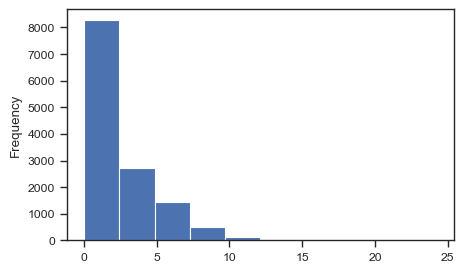

In [7]:
plt.figure(figsize=(5, 3))
df["audio_length"].plot.hist();

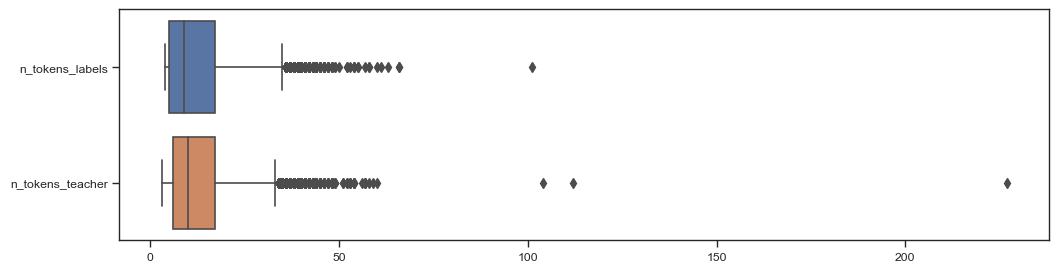

In [8]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=df[["n_tokens_labels", "n_tokens_teacher"]], orient="h");

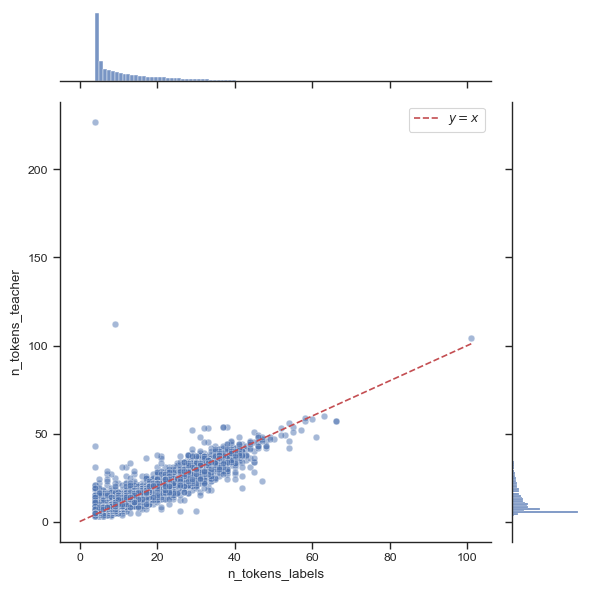

In [9]:
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.5)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'r--', label=r"$y=x$")
plt.legend()
plt.tight_layout()

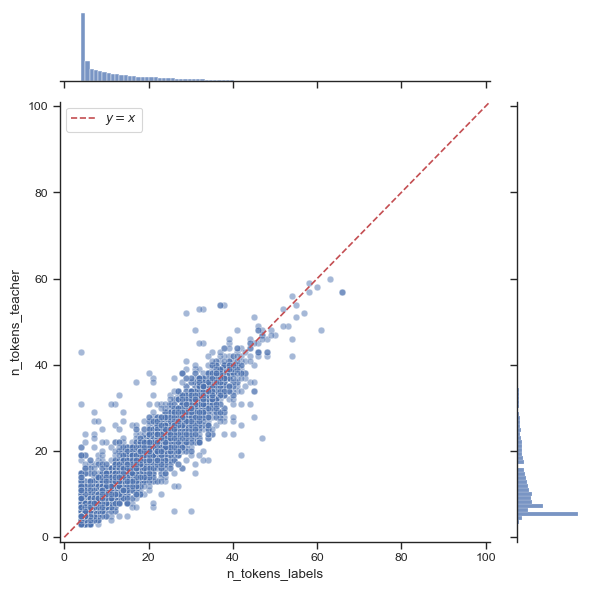

In [10]:
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.5)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'r--', label=r"$y=x$")
plt.legend()
plt.xlim(-1, line_max_coord)
plt.ylim(-1, line_max_coord)
plt.tight_layout()

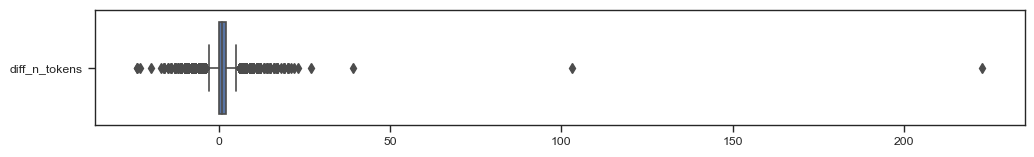

In [11]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h");

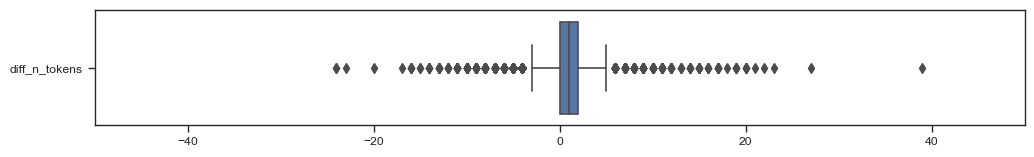

In [12]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")
plt.xlim(-50, 50);

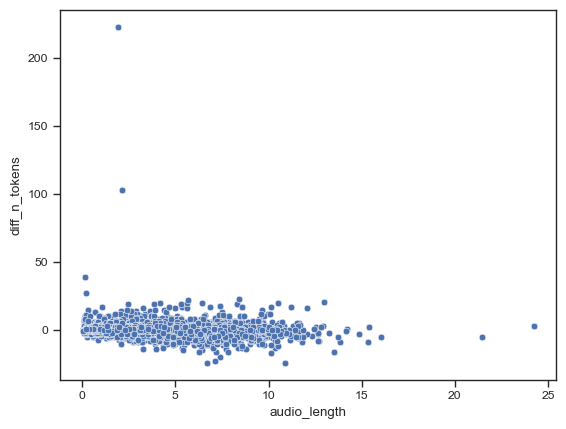

In [13]:
sns.scatterplot(data=df, x="audio_length", y="diff_n_tokens");

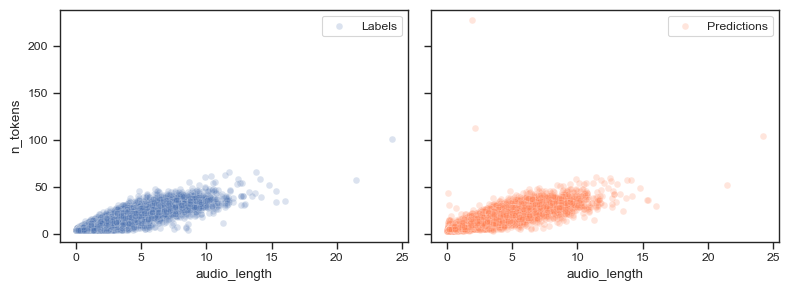

In [14]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="n_tokens_labels", label="Labels", alpha=0.2, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="n_tokens_teacher", label="Predictions", c="coral", alpha=0.2, ax=axis[1])
axis[0].set_ylabel("n_tokens")
fig.tight_layout()

## Criteria for filtering

### `high_diff_n_tokens`

In [46]:
THRESH_DELTA_N_TOKENS = int(df["diff_n_tokens"].mean() + 1.5 * df["diff_n_tokens"].std())
THRESH_DELTA_N_TOKENS

5

In [47]:
df["high_diff_n_tokens"] = (df["diff_n_tokens"] > THRESH_DELTA_N_TOKENS)

df["high_diff_n_tokens"].value_counts()

False    12844
True       254
Name: high_diff_n_tokens, dtype: int64

In [48]:
df_candidates = df[df["high_diff_n_tokens"]]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 59
Reference:  um oh we just
Prediction:   um, i will just have to zoom.

Idx = 99
Reference:  this is yeah well like a cat you know soft yeah
Prediction:   yeah, well, like a cat, you know. soft, yeah. ha ha.

Idx = 298
Reference:  i don't yeah i mean it but like i mean just i mean like your phone even just has so like it can vibrate
Prediction:   i don't, yeah, i mean, but like, i mean, just, i mean, like your phone even just has sound, like it can vibrate.

Idx = 324
Reference:  but even just a thing to attach it to the w you know if you had a thing a pretty object attached to the wall
Prediction:   but even just a thing to attach it to the wall. you know, if you had a thing, a pretty object, to attach it to the wall.

Idx = 463
Reference:  what if yeah what if the squishy oh so so you're saying the squishy part's like detachable
Prediction:   what if, yeah, what if the squishy, oh, sorry, so you're saying the squishy part's like detachable?

Idx = 533
Reference:  so anyway if

In [49]:
list_idx_to_listen = df_candidates.index[:5]

listen_to_audio(ds, list_idx_to_listen, pred_col="teacher_text")

Idx: 59
Reference: um oh we just
Prediction:  um, i will just have to zoom.



Idx: 99
Reference: this is yeah well like a cat you know soft yeah
Prediction:  yeah, well, like a cat, you know. soft, yeah. ha ha.



Idx: 298
Reference: i don't yeah i mean it but like i mean just i mean like your phone even just has so like it can vibrate
Prediction:  i don't, yeah, i mean, but like, i mean, just, i mean, like your phone even just has sound, like it can vibrate.



Idx: 324
Reference: but even just a thing to attach it to the w you know if you had a thing a pretty object attached to the wall
Prediction:  but even just a thing to attach it to the wall. you know, if you had a thing, a pretty object, to attach it to the wall.



Idx: 463
Reference: what if yeah what if the squishy oh so so you're saying the squishy part's like detachable
Prediction:  what if, yeah, what if the squishy, oh, sorry, so you're saying the squishy part's like detachable?


In [50]:
eval_filter_criterion(ds, filter_fn=lambda x: x["diff_n_tokens"] <= THRESH_DELTA_N_TOKENS)

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.96,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.65,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.29,
 'WER (%)': 18.37,
 'WER ortho (%)': 38.89}

Number of rows after filtering: 12844
Total audio length after filtering: 519.38 minutes
String edit metrics after filtering:
{'Del (%)': 8.69,
 'Del ortho (%)': 12.18,
 'Ins (%)': 2.49,
 'Ins ortho (%)': 1.46,
 'Sub (%)': 5.87,
 'Sub ortho (%)': 23.91,
 'WER (%)': 17.05,
 'WER ortho (%)': 37.56}

Number of rows removed: 254 (1.94 %)
Total audio length removed: 17.13 minutes (3.19 %)
String edit metrics difference:
{'Del (%)': -0.16,
 'Del ortho (%)': -0.22,
 'Ins (%)': 1.24,
 'Ins ortho (%)': 1.19,
 'Sub (%)': 0.24,
 'Sub ortho (%)': 0.38,
 'WER (%)': 1.32,
 'WER ortho (%)': 1.33}

Relative string edit metrics difference:
{'Del (%)': -0.02,
 'Del ortho (%)': -0.02,
 'Ins (%)': 0.33,
 'Ins

**Observation:** Good criterion. Note that this also tackles the fact that the vanilla Whisper models tend to transcribe even the speeches in the background. By removing them from the training set, we hope to teach Whisper to only focus on the main speaker.

### `n_overlaps`

In [20]:
df["n_overlaps"].value_counts()

0    13076
1       21
2        1
Name: n_overlaps, dtype: int64

In [21]:
ds_candidate = ds.filter(lambda x: x["n_overlaps"] > 0)

for idx, row in enumerate(ds_candidate):
    print("Index: ", idx)
    print("Reference: ", row["text"])
    print("Pred: ", row["teacher_text"])
    print()

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Index:  0
Reference:  no uh automatic uh coffee machines
Pred:   now, automatic coffee machines.

Index:  1
Reference:  mm
Pred:   and i'm not sure if it's but i think it's because of and i think it's because of and i think it's because of and i think it's because of

Index:  2
Reference:  oh all okay all of us
Pred:   oh, okay, all of us.

Index:  3
Reference:  yeah just is that okay
Pred:   yeah, just, is that okay?

Index:  4
Reference:  wha what um well probably our target group and how it's gonna going to appeal to our target group and i dunno the the s the buttons and what it does and that sort of thing
Pred:   what, well probably our target group and how it's going to appeal to our target group in, i don't know, the buttons and what it does and that sort of thing.

Index:  5
Reference:  like uh we could do i'm trying to think of other sha like fruits that are oddly shaped
Pred:   like, we could do, i'm trying to think of other shape, like fruits that are oddly shaped.

Index:  6

In [22]:
eval_filter_criterion(ds, filter_fn=lambda x: x["n_overlaps"] == 0)

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.96,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.65,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.29,
 'WER (%)': 18.37,
 'WER ortho (%)': 38.89}

Number of rows after filtering: 13076
Total audio length after filtering: 534.52 minutes
String edit metrics after filtering:
{'Del (%)': 8.54,
 'Del ortho (%)': 11.95,
 'Ins (%)': 3.67,
 'Ins ortho (%)': 2.56,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.29,
 'WER (%)': 18.31,
 'WER ortho (%)': 38.8}

Number of rows removed: 22 (0.17 %)
Total audio length removed: 1.98 minutes (0.37 %)
String edit metrics difference:
{'Del (%)': -0.01,
 'Del ortho (%)': 0.01,
 'Ins (%)': 0.06,
 'Ins ortho (%)': 0.09,
 'Sub (%)': 0.0,
 'Sub ortho (%)': 0.0,
 'WER (%)': 0.06,
 'WER ortho (%)': 0.09}

Relative string edit metrics difference:
{'Del (%)': -0.0,
 'Del ortho (%)': 0.0,
 'Ins (%)': 0.02,
 'Ins ortho (%

### gzip compression ratio

In [23]:
df.columns

Index(['text', 'labels', 'teacher_text', 'teacher_labels', 'audio_length',
       'n_tokens_labels', 'n_tokens_teacher', 'diff_n_tokens', 'gzip_ratio',
       'teacher_gzip_ratio', 'diff_gzip_ratio', 'n_overlaps',
       'high_diff_n_tokens'],
      dtype='object')

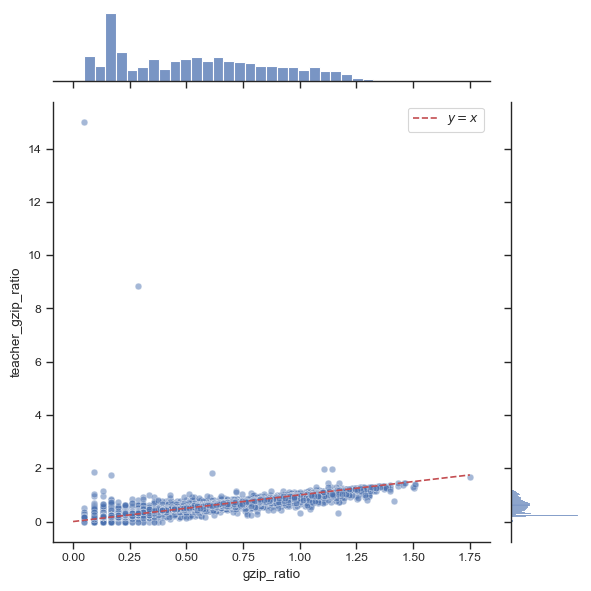

In [24]:
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.5)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'r--', label=r"$y=x$")
plt.legend()
# plt.xlim(-1, line_max_coord)
# plt.ylim(-1, line_max_coord)
plt.tight_layout()

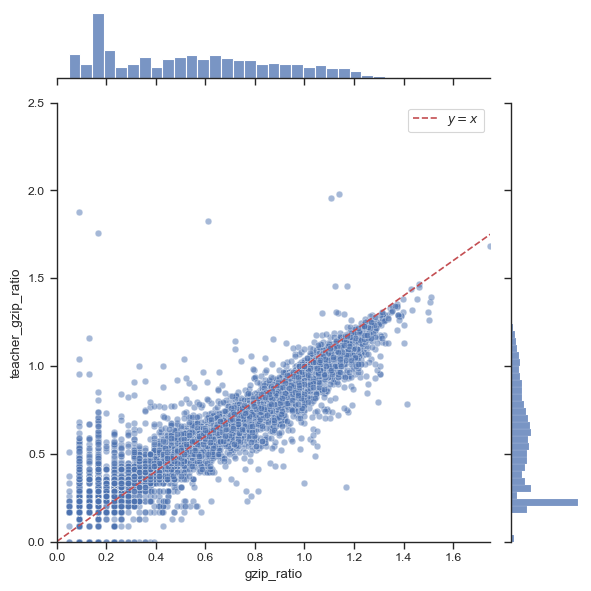

In [25]:
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.5)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'r--', label=r"$y=x$")
plt.legend()
plt.xlim(0, line_max_coord)
plt.ylim(0, 2.5)
plt.tight_layout()

In [39]:
THRESH_DIFF_GZIP = df["diff_gzip_ratio"].mean() + 1.5 * df["diff_gzip_ratio"].std()

THRESH_DIFF_GZIP

0.2818883326090002

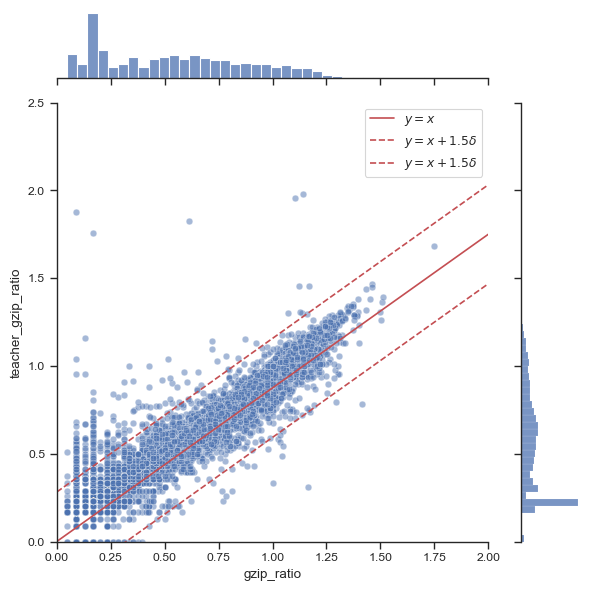

In [51]:
x_col = "gzip_ratio"
y_col = "teacher_gzip_ratio"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.5)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, 2], [0, line_max_coord], 'r', label=r"$y=x$")
plt.plot([0, 2], [THRESH_DIFF_GZIP, line_max_coord+THRESH_DIFF_GZIP], 'r--', label=r"$y=x+1.5\delta$")
plt.plot([0, 2], [-THRESH_DIFF_GZIP, line_max_coord-THRESH_DIFF_GZIP], 'r--', label=r"$y=x+1.5\delta$")
plt.legend()
plt.xlim(0, 2)
plt.ylim(0, 2.5)
plt.tight_layout()

In [41]:
df_candidates = df[df["diff_gzip_ratio"] > THRESH_DIFF_GZIP]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 749
Reference:  yeah
Prediction:   thank you. thank you.

Idx = 841
Reference:  uh
Prediction:   so, thank you.

Idx = 988
Reference:  that's
Prediction:   that's what though.

Idx = 1044
Reference:  mm
Prediction:   some people.

Idx = 1045
Reference:  yeah yeah no okay
Prediction:   that's the whole point, right? yeah, yeah, no, okay.

Idx = 1072
Reference:  two
Prediction:   and we'll be right back.

Idx = 1111
Reference:  okay
Prediction:   okay. yeah, that's what i'm talking about.

Idx = 1340
Reference:  ah okay
Prediction:   ah, okay. sorry, i should have explained that.

Idx = 1343
Reference:  mm mm
Prediction:   and then it's like, yeah.

Idx = 1357
Reference:  mm-hmm
Prediction:   mm-hmm. ha ha ha.

Idx = 1380
Reference:  rooms yeah
Prediction:   the three person rooms. the three person rooms, yeah.

Idx = 1427
Reference:  yeah
Prediction:   assuming you figured out, but just in case.

Idx = 1494
Reference:  yeah mm mm
Prediction:   yeah. it's the same thing for the pro

In [42]:
df_candidates = df[df["diff_gzip_ratio"] < - THRESH_DIFF_GZIP]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 616
Reference:  say that's the s say that's the squashy bit
Prediction:   say that's the squashy bit.

Idx = 639
Reference:  i mean i think uh and i think the handhe i think the handheld part is definitely
Prediction:   i mean, i think the hand-held part is definitely...

Idx = 816
Reference:  yeah yeah yeah
Prediction:   yeah

Idx = 878
Reference:  so you're either you're you know th you're either doing this motion to like control the channels or like once once you stop that
Prediction:   so you're either doing this motion to control the channels or once you stop that.

Idx = 1059
Reference:  three yeah
Prediction:  

Idx = 1451
Reference:  bless you
Prediction:  

Idx = 1698
Reference:  yeah sure sure
Prediction:   kv

Idx = 1778
Reference:  c that that of course is one of the main well not main but one of the important features that we need to know about
Prediction:   that of course is one of the important features that we need to know about.

Idx = 1866
Reference:  w what abo

In [44]:
eval_filter_criterion(ds, filter_fn=lambda x: np.abs(x["diff_gzip_ratio"]) <= THRESH_DIFF_GZIP)

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.96,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.65,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.29,
 'WER (%)': 18.37,
 'WER ortho (%)': 38.89}

Number of rows after filtering: 12834
Total audio length after filtering: 524.71 minutes
String edit metrics after filtering:
{'Del (%)': 8.05,
 'Del ortho (%)': 11.44,
 'Ins (%)': 2.93,
 'Ins ortho (%)': 1.79,
 'Sub (%)': 6.0,
 'Sub ortho (%)': 24.26,
 'WER (%)': 16.98,
 'WER ortho (%)': 37.49}

Number of rows removed: 264 (2.02 %)
Total audio length removed: 11.79 minutes (2.20 %)
String edit metrics difference:
{'Del (%)': 0.48,
 'Del ortho (%)': 0.52,
 'Ins (%)': 0.8,
 'Ins ortho (%)': 0.86,
 'Sub (%)': 0.11,
 'Sub ortho (%)': 0.03,
 'WER (%)': 1.39,
 'WER ortho (%)': 1.4}

Relative string edit metrics difference:
{'Del (%)': 0.06,
 'Del ortho (%)': 0.04,
 'Ins (%)': 0.21,
 'Ins ortho 